In [46]:
#Code to install imbalanced-learn. Credits: Ernest

# 1. Download imbalanced-learn from https://files.pythonhosted.org/packages/e5/4c/7557e1c2e791bd43878f8c82065bddc5798252084f26ef44527c02262af1/imbalanced_learn-0.4.3-py3-none-any.whl 
# 2. Add it to the part where we add datasets

# import os, pandas as pd
# print(os.environ['DSX_PROJECT_DIR']+'/datasets/imbalanced_learn-0.4.3-py3-none-any.whl')
# !pip install --user '/user-home/1022/DSX_Projects/Naive Baes/datasets/imbalanced_learn-0.4.3-py3-none-any.whl'

In [66]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm as cm
import matplotlib.patches as mpatches # plot t-SNE, PCA, Truncated SVD
import missingno as msno

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, average_precision_score
from sklearn.metrics import precision_recall_curve, roc_curve, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

import seaborn as sns 

from imblearn.over_sampling import SMOTE

from collections import defaultdict
from scipy.stats import hmean
from scipy.spatial.distance import cdist
from scipy import stats
import numbers 

import pylab # t-SNE 
import time # t-SNE model
from sklearn.manifold import TSNE # t-SNE
from sklearn.decomposition import PCA, TruncatedSVD # PCA, SVD

In [48]:
# #Code to import dataset
# df = pd.read_csv(os.environ['DSX_PROJECT_DIR']+'/datasets/creditcard-training.csv')
# df.head()

In [49]:
df_raw = pd.read_csv('data/creditcard-training.csv')

# Data Exploration

In [50]:
#Get shape
df_raw.shape

(227844, 32)

In [51]:
#Print head
df_raw.head()

,Seconds since reference time,Amount,"Fraud? (1: Fraud, 0: No Fraud)",Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,...,Feature 20,Feature 21,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29
0,0,149.62,0,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,...,0.462388,0.239599,0.098698,-6.399372,-0.311169,-0.991390,-0.617801,-0.551600,0.090794,0.363787
1,0,2.69,0,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,...,-0.082361,-0.078803,0.085102,13.786441,-0.143772,0.489095,1.065235,1.612727,-0.166974,-0.255425
2,1,378.66,0,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,...,1.800499,0.791461,0.247676,-10.515321,-0.165946,0.717293,0.066084,0.624501,0.207643,-1.514654
3,1,123.50,0,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,...,1.247203,0.237609,0.377436,2.961038,-0.287924,0.507757,0.178228,-0.226487,-0.054952,-1.387024
4,2,69.99,0,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,...,0.095921,0.592941,-0.270533,2.751346,-1.119670,1.345852,0.538196,-0.822843,0.753074,0.817739


In [52]:
#Rename the fraud column
df_raw = df_raw.rename( {'Fraud? (1: Fraud, 0:  No Fraud)' : 'Fraud'}, axis=1)
df_raw.head()

,Seconds since reference time,Amount,Fraud,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,...,Feature 20,Feature 21,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29
0,0,149.62,0,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,...,0.462388,0.239599,0.098698,-6.399372,-0.311169,-0.991390,-0.617801,-0.551600,0.090794,0.363787
1,0,2.69,0,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,...,-0.082361,-0.078803,0.085102,13.786441,-0.143772,0.489095,1.065235,1.612727,-0.166974,-0.255425
2,1,378.66,0,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,...,1.800499,0.791461,0.247676,-10.515321,-0.165946,0.717293,0.066084,0.624501,0.207643,-1.514654
3,1,123.50,0,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,...,1.247203,0.237609,0.377436,2.961038,-0.287924,0.507757,0.178228,-0.226487,-0.054952,-1.387024
4,2,69.99,0,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,...,0.095921,0.592941,-0.270533,2.751346,-1.119670,1.345852,0.538196,-0.822843,0.753074,0.817739


In [53]:
#Get NAs 
df_raw[df_raw.isnull().any(axis=1)].head()

,Seconds since reference time,Amount,Fraud,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,...,Feature 20,Feature 21,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29
10,10,7.80,0,0.230930,0.031967,0.253415,0.854344,NaN,-0.387226,-0.009302,...,-0.629152,-1.423236,0.048456,-13.640428,-0.095045,-0.513947,-0.671440,1.199644,1.626659,-1.720408
16,12,12.99,0,0.354574,-0.246635,-0.009212,-0.595912,-0.575682,NaN,-0.024612,...,0.288069,-0.586057,0.189380,8.579468,-0.468647,0.708380,0.936708,-0.450311,-0.267975,0.782333
25,22,26.43,0,-0.211668,-0.333321,0.010751,-0.488473,0.505751,NaN,-0.403639,...,-0.959537,0.543985,-0.104627,-10.985595,-0.279797,-0.655233,-0.180523,-0.856566,0.149451,0.475664
28,23,33.00,0,0.076804,-1.405919,0.775592,-0.942889,NaN,0.097308,0.077237,...,-0.200331,0.740228,-0.029247,-5.123601,-0.086324,0.635954,0.786796,-0.012142,-0.346188,-0.593392
42,33,14.80,0,0.235545,-1.347811,0.504648,-0.798405,0.759710,NaN,-0.087329,...,0.119168,0.850893,-0.176267,5.560997,-0.365439,0.481917,0.398299,-0.387003,0.148455,-0.243501


Text(0,0.5,'Frequency')

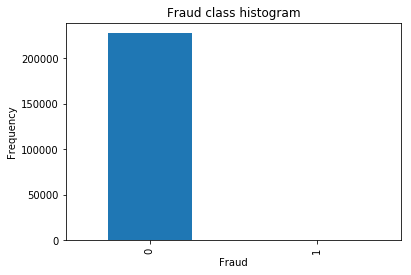

In [54]:
#EDA

#Checking the Target Classes
count_classes = pd.value_counts(df_raw['Fraud'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Fraud")
plt.ylabel("Frequency")

#The historgram shows that there is a need for resampling 


## Data Cleaning

In [55]:
#Since the value of amount has a very different scale from the rest, we should condier normalising the column "amount"
#Method 1 Drop Seconds Since Reference Time Column
#Seconds since reference time column will be dropped as well since it has no significant contribution to the model building as it is simply a cheorogrphical order of the reference time
#df['normAmount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
#df = df.drop(['Seconds since reference time','Amount'],axis=1)
#df.head()

df = df_raw.copy()
#Method 2 Normalize Seconds Since Reference Time Column
df['normAmount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df['normTime'] = StandardScaler().fit_transform(df['Seconds since reference time'].values.reshape(-1, 1))
df = df.drop(['Amount'],axis=1)
df.head()
df = df.drop(['Seconds since reference time'],axis=1)

#Deciding which method to choose depends on ?????


C:\Users\Muskaan Gupta\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Muskaan Gupta\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


There are missing values so we will use Sklearn Imputer to impute

## Handle Missing Values

In [56]:
df.head()

,Fraud,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29,normAmount,normTime
0,0,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,...,0.098698,-6.399372,-0.311169,-0.991390,-0.617801,-0.551600,0.090794,0.363787,0.234706,-2.000787
1,0,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,...,0.085102,13.786441,-0.143772,0.489095,1.065235,1.612727,-0.166974,-0.255425,-0.351832,-2.000787
2,0,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,...,0.247676,-10.515321,-0.165946,0.717293,0.066084,0.624501,0.207643,-1.514654,1.149024,-2.000762
3,0,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,...,0.377436,2.961038,-0.287924,0.507757,0.178228,-0.226487,-0.054952,-1.387024,0.130436,-2.000762
4,0,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,...,-0.270533,2.751346,-1.119670,1.345852,0.538196,-0.822843,0.753074,0.817739,-0.083174,-2.000737


In [57]:
df[df.isnull().any(axis=1)].head()

,Fraud,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29,normAmount,normTime
10,0,0.230930,0.031967,0.253415,0.854344,NaN,-0.387226,-0.009302,0.313894,0.027740,...,0.048456,-13.640428,-0.095045,-0.513947,-0.671440,1.199644,1.626659,-1.720408,-0.331433,-2.000534
16,0,0.354574,-0.246635,-0.009212,-0.595912,-0.575682,NaN,-0.024612,0.196002,0.013802,...,0.189380,8.579468,-0.468647,0.708380,0.936708,-0.450311,-0.267975,0.782333,-0.310715,-2.000484
25,0,-0.211668,-0.333321,0.010751,-0.488473,0.505751,NaN,-0.403639,-0.227404,0.742435,...,-0.104627,-10.985595,-0.279797,-0.655233,-0.180523,-0.856566,0.149451,0.475664,-0.257063,-2.000231
28,0,0.076804,-1.405919,0.775592,-0.942889,NaN,0.097308,0.077237,0.457331,-0.038500,...,-0.029247,-5.123601,-0.086324,0.635954,0.786796,-0.012142,-0.346188,-0.593392,-0.230836,-2.000205
42,0,0.235545,-1.347811,0.504648,-0.798405,0.759710,NaN,-0.087329,0.258315,-0.264775,...,-0.176267,5.560997,-0.365439,0.481917,0.398299,-0.387003,0.148455,-0.243501,-0.303490,-1.999952


In [62]:
#Use sklearn Impute to impute missing values
features = df.values
imp = SimpleImputer(missing_values = np.nan, strategy='mean')

#Only feature 5 and feature 6 have NaN
features[:,[5,6]] = imp.fit_transform(features[:,[5,6]])

df1 = pd.DataFrame(features)
df1.columns = df.columns
df = df1
df[df.isnull().any(axis=1)]

,Fraud,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29,normAmount,normTime


In [59]:
#Get difference in means between Fraud and not-fraud
df.groupby('Fraud').mean()

,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Feature 10,...,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29,normAmount,normTime
Fraud,,,,,,,,,,,,,,,,,,,,,
0.0,0.049387,0.002841,0.028799,-0.018164,-0.008677,0.009279,-0.007071,-0.022976,-0.009824,0.001263,...,0.002776,0.026436,0.045807,0.016831,-0.032826,0.068994,0.009538,0.007167,-0.000255,0.000545
1.0,-0.098209,-4.559229,-7.423533,-2.589217,0.761240,0.371774,0.765659,0.013088,-0.060036,-0.083433,...,0.663762,0.613894,-7.024019,-0.048627,-6.685076,4.046820,-6.135121,-2.696376,0.139044,-0.297025


## Check for Duplicates

In [60]:
df[df.duplicated()==True]

,Fraud,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29,normAmount,normTime


There are no duplicates. So we can move on.

# Feature Selection

In [85]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

df = df.sample(frac=1)

# amount of fraud classes 417 rows.
fraud_df = df.loc[df['Fraud'] == 1]
non_fraud_df = df.loc[df['Fraud'] == 0][:417]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,Fraud,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29,normAmount,normTime
150747,0.0,-1.115911,-0.675351,-0.032018,0.828254,0.869542,0.217009,0.103832,0.875372,-0.255519,...,-0.510035,-3.487370,2.106921,1.960024,-2.182021,1.301619,0.188168,0.179630,-0.218860,0.378920
168105,0.0,-0.320531,1.419618,-0.593124,-0.486781,1.067749,0.318758,0.496114,1.207528,-0.225538,...,-0.192105,-6.838232,-0.070634,1.410533,0.235724,0.268661,0.961242,-0.863063,0.099498,1.013132
75511,1.0,0.041433,-4.180758,-4.285071,-2.536452,0.930239,0.270459,1.208054,0.277612,0.019266,...,-0.555548,-4.171221,-5.419590,0.763326,-2.820042,2.338323,-3.245109,-1.184468,0.319735,-0.580790
145020,0.0,-0.189163,0.710521,0.031003,0.823806,-0.122396,0.158119,-0.310660,-0.511127,-0.099309,...,-0.077881,-12.838438,-1.527048,-0.434067,0.424158,1.302137,-0.525394,0.732980,-0.202932,0.190517
150715,1.0,-1.161999,-11.646834,-18.383852,-7.402731,1.941697,0.208879,0.339007,1.342923,0.239217,...,2.083013,0.699509,-9.935680,-0.148288,-14.979755,7.093182,-15.346099,-4.988837,-0.317062,0.377730


### Correlation Matrix

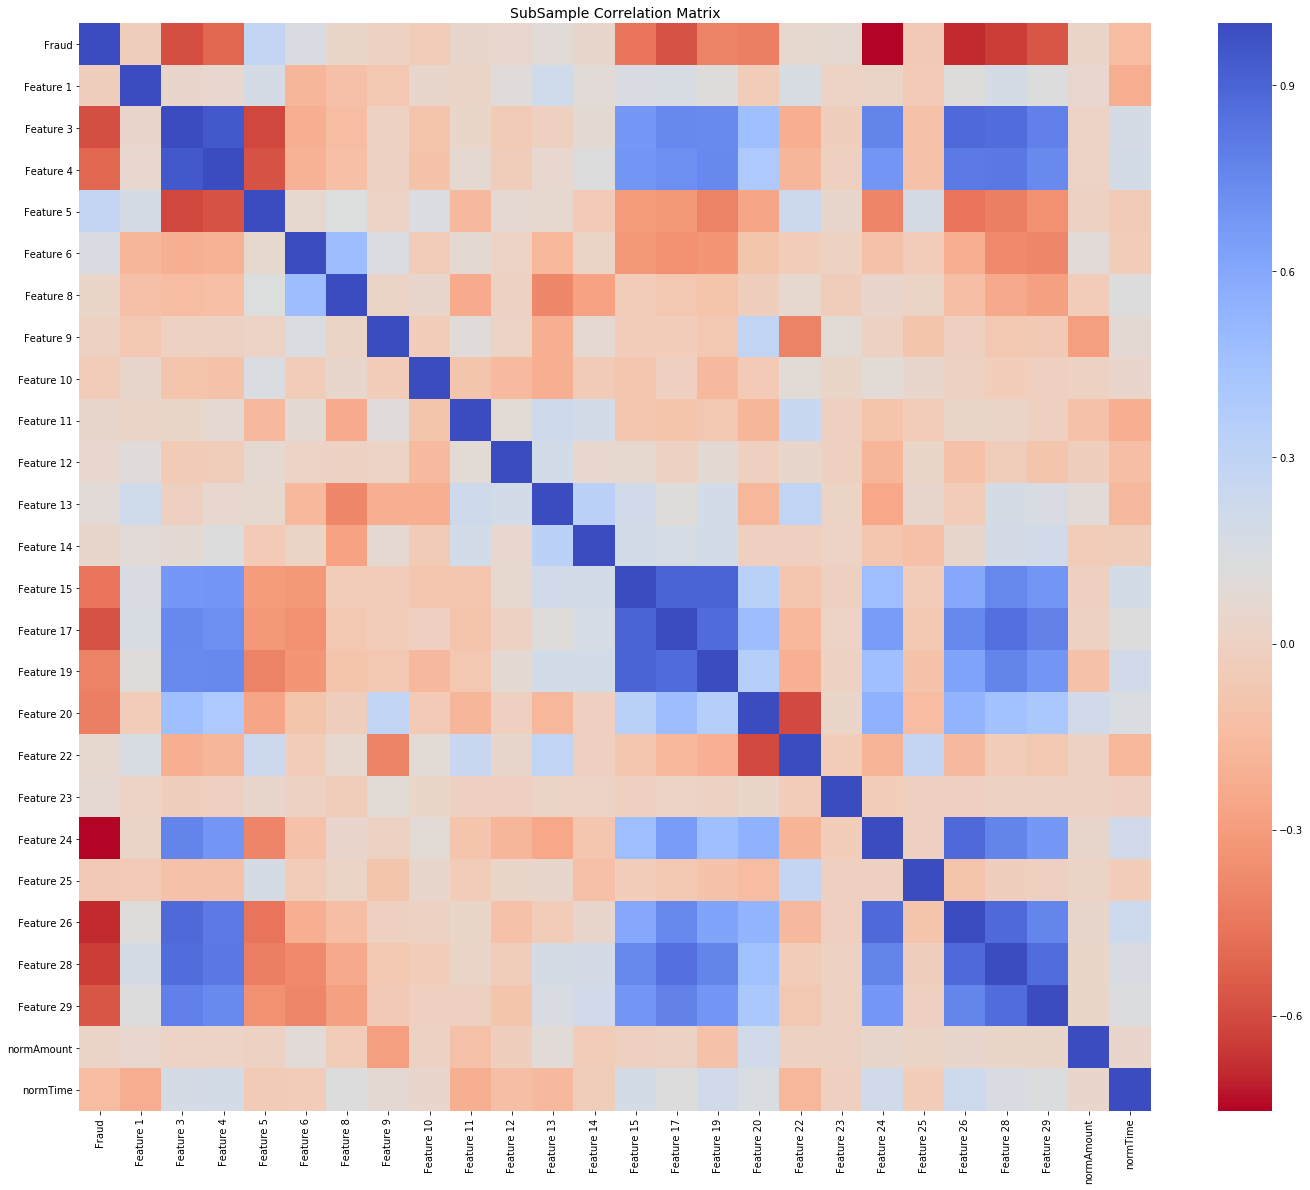

In [88]:
# Shuffle dataframe rows
df_sample = normal_distributed_df.sample(frac=1, random_state=42)

f, ax1 = plt.subplots(1, 1, figsize=(24,20))

sub_sample_corr = df_sample.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title('SubSample Correlation Matrix', fontsize=14)
plt.show()

<b>Negative Correlations</b>: Features (7 and 8), (15 and 16), (16 and 17), (16 and 21), (24 and 27), (26 and 27) are negatively correlated. <br/>
<b>Positive Correlations</b>:Features (2,3, and 4), (2 and 26), (15 and 21) are positively correlated. Notice how the higher these values are, the more likely the end result will be a fraud transaction.

So now we will be removing features 7, 16, 27, 2, 21

In [87]:
normal_distributed_df.drop(['Feature 2', 'Feature 3', 'Feature 7', 'Feature 16', 'Feature 18', 'Feature 21', 'Feature 27'], axis=1, inplace=True)

## Random Forest 

In [ ]:
# Build RF classifier to use in feature selection
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

# Build step forward feature selection
sfs1 = sfs(clf,
           k_features=5,
           forward=True,
           floating=False,
           verbose=2,
           scoring='accuracy',
           cv=5)

# Perform SFFS
sfs1 = sfs1.fit(X_train, y_train)

## T-SNE

In [82]:
# New_df is from the random undersample data (fewer instances)
# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

X = new_df.drop('Fraud', axis=1)
y = new_df['Fraud']

# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

T-SNE took 8.8 s


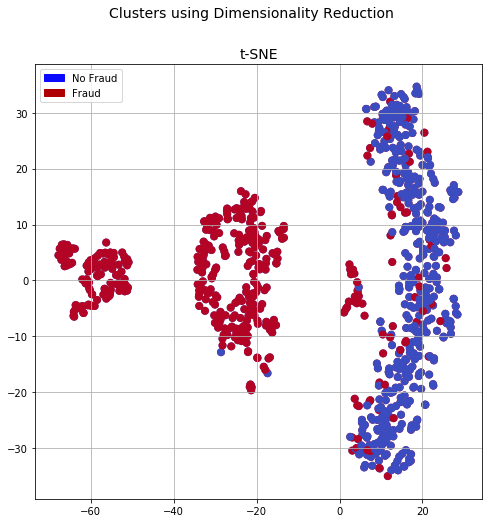

In [83]:
f, ax1 = plt.subplots(1, 1, figsize=(8,8))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)

blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])

plt.show()